In [1]:
import xarray
import numpy as np
from paths import heat_out_trefht_tmax_members_1920_1950_CONTROL as tmax_paths
from paths import heat_out_trefht_tmin_members_1920_1950_CONTROL as tmin_paths
from paths import population_2020_aggregated
from os.path import exists
import dask

In [82]:
exp_num = "3136"
variable = "HWF"

all_member_paths = [path for path in tmin_paths()[0] if exp_num in path]
xghg_member_paths = [path for path in tmin_paths()[1] if exp_num in path]
xaer_member_paths = [path for path in tmin_paths()[2] if exp_num in path]

all_data = xarray.open_mfdataset(all_member_paths, concat_dim="member", combine="nested")[f"{variable}_tn90"].dt.days
xaer_data = xarray.open_mfdataset(xaer_member_paths, concat_dim="member", combine="nested")[f"{variable}_tn90"].dt.days
xghg_data = xarray.open_mfdataset(xghg_member_paths, concat_dim="member", combine="nested")[f"{variable}_tn90"].dt.days

# Shift data
all_data = all_data.assign_coords(lon=(((all_data.lon + 180) % 360) - 180)).sortby('lon')
xaer_data = xaer_data.assign_coords(lon=(((xaer_data.lon + 180) % 360) - 180)).sortby('lon')
xghg_data = xghg_data.assign_coords(lon=(((xghg_data.lon + 180) % 360) - 180)).sortby('lon')
print("pop stuff")
pop_data =  xarray.open_dataset("../data/population/population_histsoc_30arcmin_annual_1901_2020.nc", decode_times=False)["popc"]

lat_delta = (all_data.lat.values[1] - all_data.lat.values[0]) / 2
lon_delta = (all_data.lon.values[1] - all_data.lon.values[0]) / 2
lats = np.append(all_data.lat.values - lat_delta, all_data.lat.values[-1::])
lons = np.append(all_data.lon.values - lon_delta, all_data.lon.values[-1::])

print("Resampling dynamic population data")
resampled_pop = pop_data.where(pop_data > 0).astype(np.float64).groupby_bins("lat", lats).sum().groupby_bins("lon", lons).sum()
resampled_pop = resampled_pop.rename({"lat_bins":"lat", "lon_bins":"lon"})
error = resampled_pop.sum(dim="lat").sum(dim="lon") - pop_data.sum(dim="lat").sum(dim="lon")

print("Creating weighted versions from 1920 to 2020")
resampled_pop = resampled_pop.sel(time=slice(19,119)).assign_coords({"time":all_data.sel(time=slice(1920,2020)).time, 'lat':all_data.lat.values, 'lon':all_data.lon.values})
all_weighted = (resampled_pop * all_data.sel(time=slice(1920,2020))) / resampled_pop.sum(dim="lat").sum("lon")
xaer_weighted = (resampled_pop * xaer_data.sel(time=slice(1920,2020))) / resampled_pop.sum(dim="lat").sum("lon")
xghg_weighted = (resampled_pop * xghg_data.sel(time=slice(1920,2020))) / resampled_pop.sum(dim="lat").sum("lon")


/projects/dgs/rh5_local/anaconda/climate/envs/heat/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/projects/dgs/rh5_local/anaconda/climate/envs/heat/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[

pop stuff
Resampling dynamic population data
Creating weighted versions from 1920 to 2020


In [83]:
all_weighted.to_netcdf("../data/population/dynamically_weighted/all_dyn_weighted.nc")
xaer_weighted.to_netcdf("../data/population/dynamically_weighted/xaer_dyn_weighted.nc")
xghg_weighted.to_netcdf("../data/population/dynamically_weighted/xghg_dyn_weighted.nc")

In [ ]:
from paths import heat_out_trefht_tmin_members_1920_1950_CONTROL as tmin, heat_out_trefht_tmax_members_1920_1950_CONTROL as tmax, land_mask
from paths import population_weighted_tmin_heat_outputs as ptmin, population_2020_aggregated
import xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import colors
from matplotlib import rc
import numpy as np

ds = xarray.open_rasterio(population_2020_aggregated()).astype(np.float64).rename({"x":"lon", "y":"lat"}).load()
ds = ds.where(ds>0)
world_pop = ds.sum(dim="lat").sum(dim="lon")
europe_pop = ds.where(ds.lat>35).where(ds.lat<65).where(ds.lon>-20).where(ds.lon<60).sum(dim="lat").sum(dim="lon")
e_na_pop = ds.where(ds.lat>25).where(ds.lat<55).where(ds.lon>-100).where(ds.lon<-60).sum(dim="lat").sum(dim="lon")
trop_s_amer_pop = ds.where(ds.lat>-25).where(ds.lat<10).where(ds.lon>-90).where(ds.lon<-55).sum(dim="lat").sum(dim="lon")
africa_pop = ds.where(ds.lat>-20).where(ds.lat<15).where(ds.lon>-10).where(ds.lon<45).sum(dim="lat").sum(dim="lon")
se_asia_pop = ds.where(ds.lat>20).where(ds.lat<50).where(ds.lon>95).where(ds.lon<130).sum(dim="lat").sum(dim="lon")



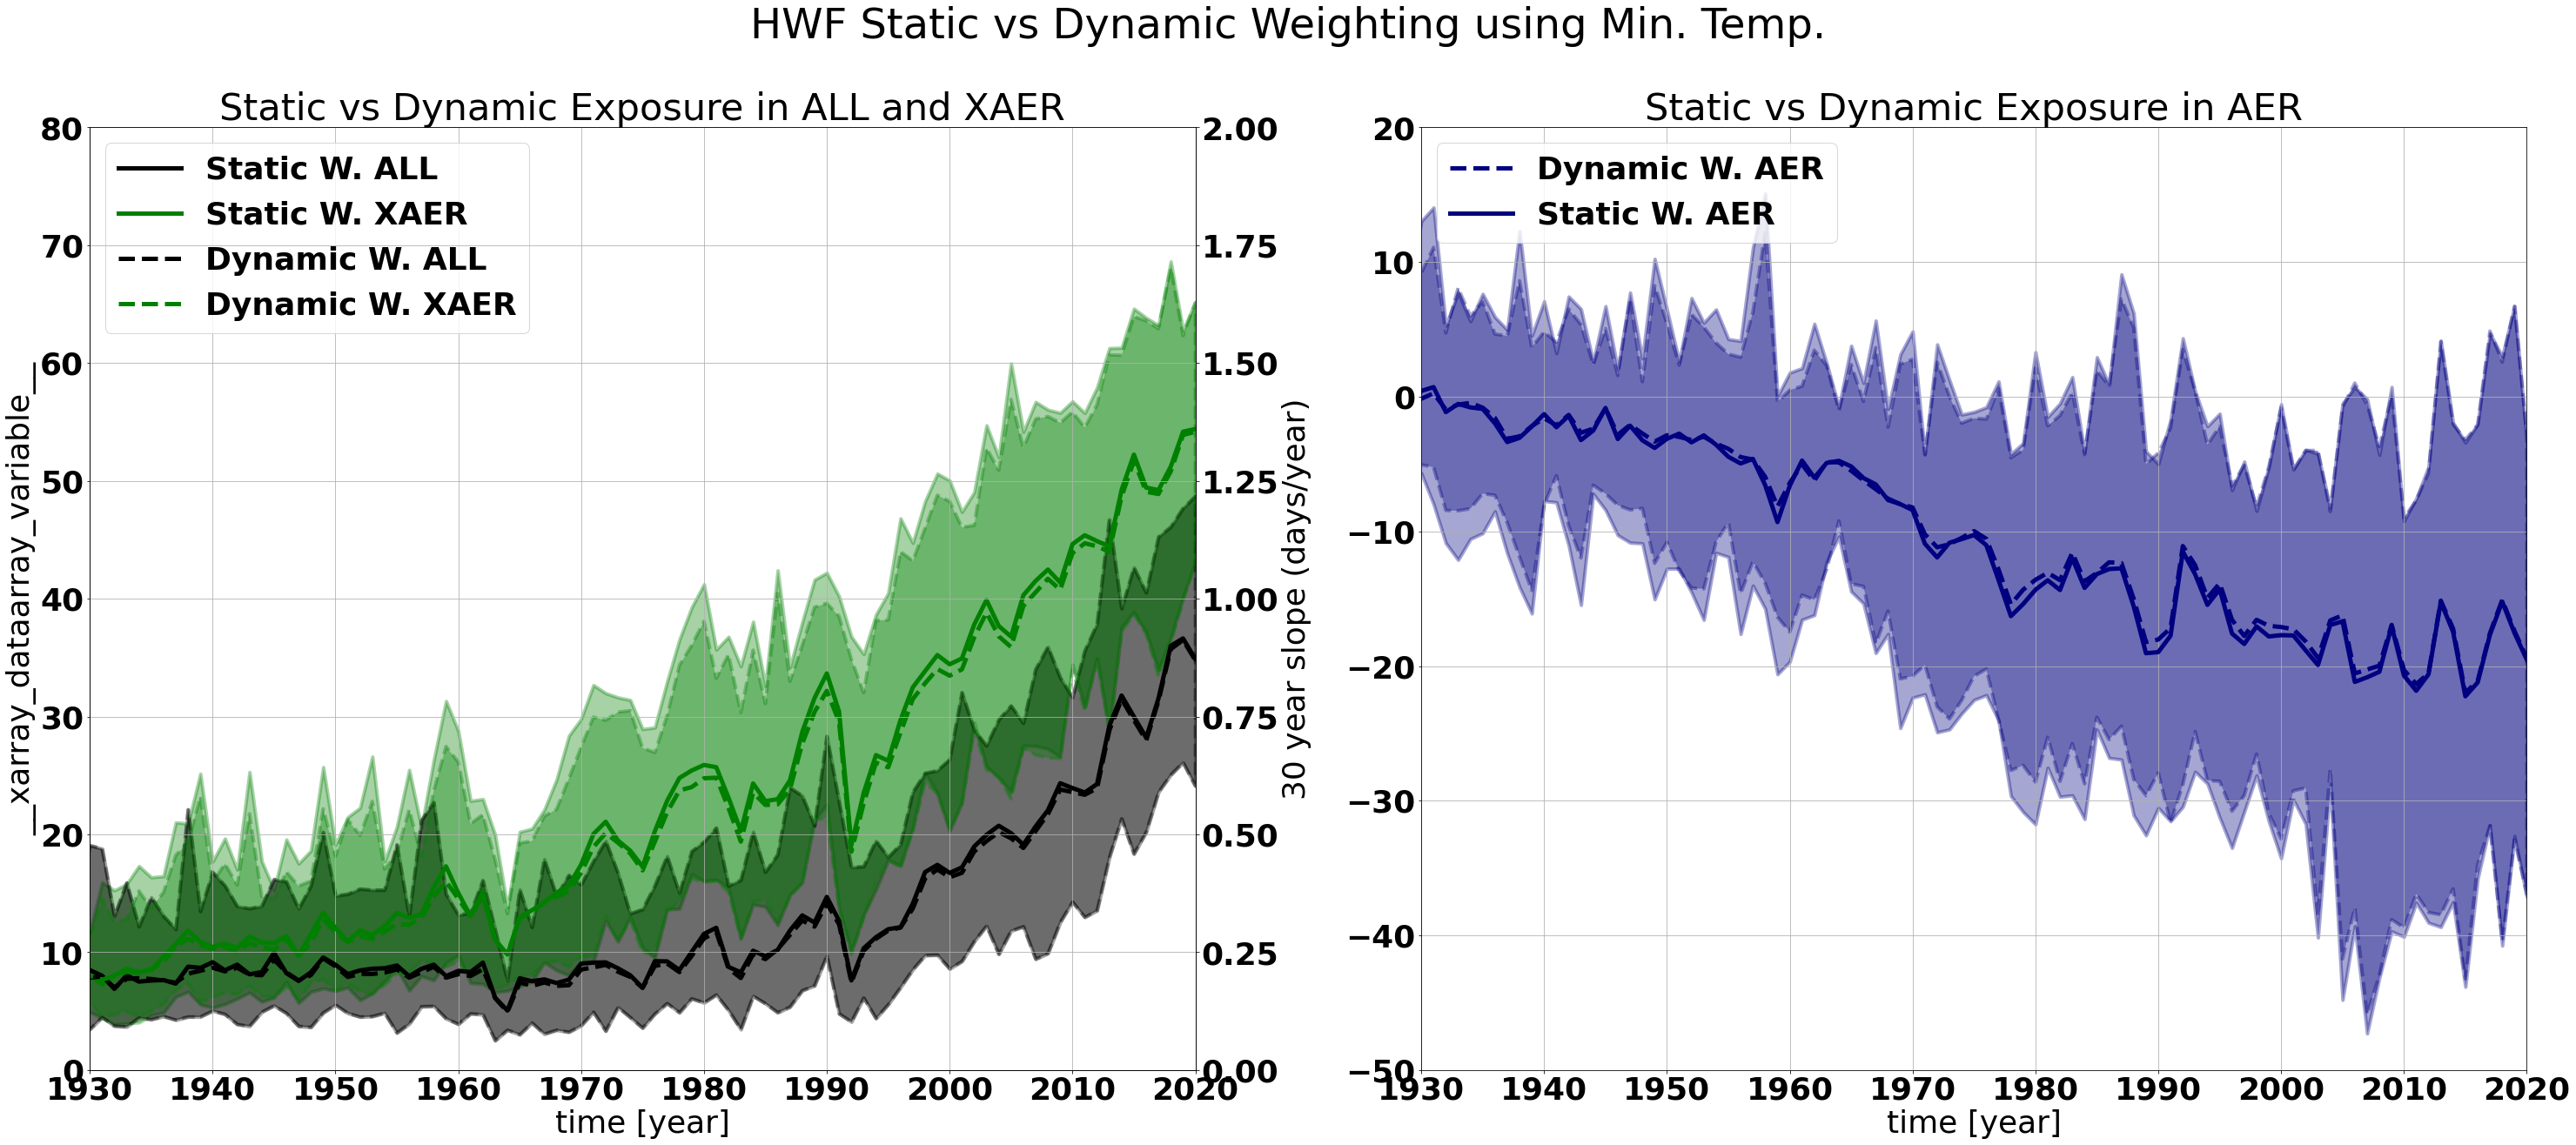

In [98]:

def poly_fit(ds):
    coeff = ds.mean(dim="member").polyfit(dim="time", deg=1)["polyfit_coefficients"].values
    print(f"{txt} -> {coeff}")
    return ds.time.values*coeff[0] + coeff[1]


def poly_fit_c(ds):
    coeff = ds.mean(dim="member").polyfit(dim="time", deg=1)["polyfit_coefficients"].values
    return coeff

mean_lw = 5
mean_bls = "-"
span_a = 0.3
bls_a = 0.35
reg_pt = 14.0

sw_all_c = "black"
dw_all_c = "black"
dw_xaer_c = "green"
sw_xaer_c = "green"
sw_c = "navy"
dw_c = "navy"

sw_ls = "-"
dw_ls = "--"
bls_lw = 4

def decadal_regressions(ds):
    # (Slope, x_init, x_final)
    #decades = [1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030, 2040, 2050]
    decades = [1945, 1955, 1965, 1975, 1985, 1995, 2005]
    regs = [poly_fit_c(ds.sel(time=slice(1930, 1960)))[0],
            poly_fit_c(ds.sel(time=slice(1940, 1970)))[0],
            poly_fit_c(ds.sel(time=slice(1950, 1980)))[0],
            poly_fit_c(ds.sel(time=slice(1960, 1990)))[0],
            poly_fit_c(ds.sel(time=slice(1970, 2000)))[0],
            poly_fit_c(ds.sel(time=slice(1980, 2010)))[0],
            poly_fit_c(ds.sel(time=slice(1990, 2020)))[0]]
    
    return decades, regs


def plot_regs(ax, all_regs, xaer_regs, decades, a_c=all_c, b_c=xaer_c):
    ax.scatter(decades, all_regs, color=a_c, marker="*", linewidths=reg_pt)
    ax.scatter(decades, xaer_regs, color=b_c, marker="*", linewidths=reg_pt)
    for index, year in enumerate(decades):
        if all_regs[index] < xaer_regs[index]:
            ax.plot([year, year], [all_regs[index], xaer_regs[index]], color="red", linewidth=reg_pt/2, linestyle="--")
        else:
            ax.plot([year, year], [all_regs[index], xaer_regs[index]], color="blue", linewidth=reg_pt/2, linestyle="--")

    
exp_num = "3136"
var = "HWF"

#Mask for land
landmask = xarray.open_dataset(land_mask())["__xarray_dataarray_variable__"].load()

all_dw_hwf = xarray.open_dataset("../data/population/dynamically_weighted/all_dyn_weighted.nc")["__xarray_dataarray_variable__"].sum(dim="lat").sum(dim="lon").load()
xaer_dw_hwf = xarray.open_dataset("../data/population/dynamically_weighted/xaer_dyn_weighted.nc")["__xarray_dataarray_variable__"].sum(dim="lat").sum(dim="lon").load()

all_min, xghg_min, xaer_min = ptmin()
all_w_hwf = xarray.open_mfdataset([path for path in all_min if exp_num in path and var in path], concat_dim="member", combine="nested").days.sel(time=slice(1920, 2020)).sum(dim="lat").sum(dim="lon").load()
xaer_w_hwf = xarray.open_mfdataset([path for path in xaer_min if exp_num in path and var in path], concat_dim="member", combine="nested").days.sel(time=slice(1920, 2020)).sum(dim="lat").sum(dim="lon").load()

all_w_hwf = all_w_hwf / world_pop.sel(band=1).drop_vars("band")
xaer_w_hwf = xaer_w_hwf / world_pop.sel(band=1).drop_vars("band")

decades, all_dw_hwf_r = decadal_regressions(all_dw_hwf)
decades, all_w_hwf_r = decadal_regressions(all_w_hwf)

decades, xaer_dw_hwf_r = decadal_regressions(xaer_dw_hwf)
decades, xaer_w_hwf_r = decadal_regressions(xaer_w_hwf)

aer_dw_hwf = all_dw_hwf - xaer_dw_hwf
aer_w_hwf = all_w_hwf - xaer_w_hwf

decades, aer_dw_hwf_r = decadal_regressions(aer_dw_hwf)
decades, aer_w_hwf_r = decadal_regressions(aer_w_hwf)

aer_dw_hwf = all_dw_hwf - xaer_dw_hwf
aer_w_hwf = all_w_hwf - xaer_w_hwf

rc('font', **{'family': 'normal', 'weight': 'bold', 'size': 36})
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(42, 19), facecolor='w')
f.suptitle(f"{var} Static vs Dynamic Weighting using Min. Temp.", fontsize=48)
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'

all_w_hwf.mean(dim="member").plot(ax=ax1, linestyle=sw_ls, linewidth=mean_lw, color=sw_all_c, label="Static W. ALL")
ax1.fill_between(all_w_hwf.time, all_w_hwf.min(dim="member"), all_w_hwf.max(dim="member"), color=sw_all_c, linestyle=sw_ls, linewidth=bls_lw, alpha=bls_a)
xaer_w_hwf.mean(dim="member").plot(ax=ax1, linestyle=sw_ls, linewidth=mean_lw, color=sw_xaer_c, label="Static W. XAER")
ax1.fill_between(xaer_w_hwf.time, xaer_w_hwf.min(dim="member"), xaer_w_hwf.max(dim="member"), color=sw_xaer_c, linestyle=sw_ls, linewidth=bls_lw, alpha=bls_a)
ax11 = ax1.twinx()
#plot_regs(ax11, xaer_w_hwf_r, all_w_hwf_r, decades, a_c=sw_xaer_c, b_c=sw_all_c)

all_dw_hwf.mean(dim="member").plot(ax=ax1, linestyle=dw_ls, linewidth=mean_lw, color=dw_all_c, label="Dynamic W. ALL")
ax1.fill_between(all_w_hwf.time, all_w_hwf.min(dim="member"), all_w_hwf.max(dim="member"), color=dw_all_c, linestyle=dw_ls, linewidth=bls_lw, alpha=bls_a)
xaer_dw_hwf.mean(dim="member").plot(ax=ax1, linestyle=dw_ls, linewidth=mean_lw, color=dw_xaer_c, label="Dynamic W. XAER")
ax1.fill_between(xaer_dw_hwf.time, xaer_dw_hwf.min(dim="member"), xaer_dw_hwf.max(dim="member"), color=dw_xaer_c, linestyle=dw_ls, linewidth=bls_lw, alpha=bls_a)
#plot_regs(ax11, xaer_dw_hwf_r, all_dw_hwf_r, decades, a_c=dw_xaer_c, b_c=dw_all_c)

ax11.grid()
ax1.grid(axis="x")
ax1.legend(loc='upper left')
ax11.set_ylabel('30 year slope (days/year)')
ax11.set_title("Static vs Dynamic Exposure in ALL and XAER")

aer_dw_hwf.mean(dim="member").plot(ax=ax2, linestyle=dw_ls, linewidth=mean_lw, color=dw_c, label="Dynamic W. AER")
aer_w_hwf.mean(dim="member").plot(ax=ax2, linestyle=sw_ls, linewidth=mean_lw, color=w_c, label="Static W. AER")
ax2.fill_between(aer_dw_hwf.time, aer_dw_hwf.min(dim="member"), aer_dw_hwf.max(dim="member"), color=dw_c, linestyle=dw_ls, linewidth=bls_lw, alpha=bls_a)
ax2.fill_between(aer_w_hwf.time, aer_w_hwf.min(dim="member"), aer_w_hwf.max(dim="member"), color=w_c, linestyle=sw_ls, linewidth=bls_lw, alpha=bls_a)
#ax33 = ax3.twinx()
#plot_regs(ax22, aer_uw_hwf_r, aer_w_hwf_r, decades, a_c=uw_c, b_c=w_c)
ax2.grid()
ax2.legend(loc='upper left')
#ax33.set_ylabel('30 year slope (days/year)')
ax2.set_title("Static vs Dynamic Exposure in AER")


ax11.set_ylim(0, 2)
ax1.set_ylim(0, 80)
ax11.set_xlim(1930, 2020)

ax2.set_ylim(-50, 20)
ax2.set_xlim(1930, 2020)


f.tight_layout()